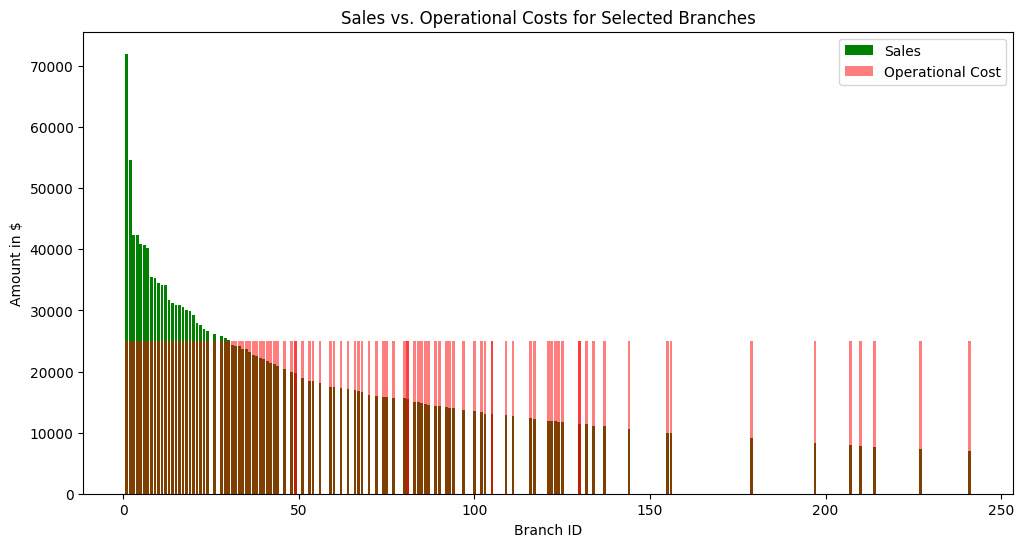

Total Potential Sales: $5,985,492.97
Total Sales Achieved: $2,158,338.42
Percentage of Sales Achieved: 36.06%
Total Operational Costs: $65,410,000.00
Selected Operational Costs: $2,625,000.00
Percentage of Costs Saved: 95.99%
Total Profit: $-466,661.58
Coverage Percentage: 3.93%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# Step 1: Load the Excel file
file_path = '/content/Fawry - Data Science - AI Task.xlsx'
type_a_data = pd.read_excel(file_path, sheet_name='Type A')
type_b_data = pd.read_excel(file_path, sheet_name='Type B')

# Step 2: Prepare the data
type_a_data['Type'] = 'A'
type_b_data['Type'] = 'B'
type_b_data['Estimated_Sales'] = 0  # Assuming no sales data for Type B

# Combine Type A and Type B data for distance calculations
all_locations = pd.concat([type_a_data[['ID', 'Latitude', 'Longitude', 'Estimated_Sales', 'Type']],
                           type_b_data[['ID', 'Latitude', 'Longitude', 'Estimated_Sales', 'Type']]],
                          ignore_index=True)

# Step 3: Use KDTree for efficient spatial queries
coords = all_locations[['Latitude', 'Longitude']].values
kdtree = KDTree(coords)

def find_locations_within_radius(kdtree, locations, radius_km):
    radius_deg = radius_km / 111.0  # Convert km to degrees
    neighbors = []

    for i, coord in enumerate(locations):
        indices = kdtree.query_ball_point(coord, radius_deg)
        neighbors.append(indices)

    return neighbors

# Step 4: Find all locations within a 5 km radius
radius_km = 5
neighbors_within_radius = find_locations_within_radius(kdtree, coords, radius_km)

# Step 5: Optimize branch selection to maximize coverage and sales
selected_branches = []
visited = set()

for i, cluster in enumerate(neighbors_within_radius):
    if i in visited:
        continue
    cluster_sales = 0
    best_branch = None
    max_sales = 0

    for idx in cluster:
        if all_locations.loc[idx, 'Estimated_Sales'] > max_sales:
            best_branch = idx
            max_sales = all_locations.loc[idx, 'Estimated_Sales']
        cluster_sales += all_locations.loc[idx, 'Estimated_Sales']

    if best_branch is not None:
        operational_cost = 25000 if all_locations.loc[best_branch, 'Type'] == 'A' else 15000
        if cluster_sales > operational_cost:
            selected_branches.append(best_branch)
            visited.update(cluster)

# Step 6: Output results to an Excel file
result_df = all_locations.loc[selected_branches, ['ID', 'Type', 'Latitude', 'Longitude', 'Estimated_Sales']]
output_file_path = 'Recommended_Branches.xlsx'
result_df.to_excel(output_file_path, index=False)

# Step 7: Visualization
result_df['Operational_Cost'] = result_df['Type'].apply(lambda x: 25000 if x == 'A' else 15000)

plt.figure(figsize=(12, 6))
plt.bar(result_df['ID'], result_df['Estimated_Sales'], color='green', label='Sales')
plt.bar(result_df['ID'], result_df['Operational_Cost'], color='red', alpha=0.5, label='Operational Cost')
plt.xlabel('Branch ID')
plt.ylabel('Amount in $')
plt.title('Sales vs. Operational Costs for Selected Branches')
plt.legend()
plt.show()

# Step 8: Calculate and display metrics
total_potential_sales = type_a_data['Estimated_Sales'].sum()
total_sales_achieved = result_df['Estimated_Sales'].sum()
percentage_sales_achieved = (total_sales_achieved / total_potential_sales) * 100
total_operational_costs = (len(type_a_data) * 25000) + (len(type_b_data) * 15000)
selected_operational_costs = result_df['Operational_Cost'].sum()
percentage_costs_saved = ((total_operational_costs - selected_operational_costs) / total_operational_costs) * 100
total_profit = total_sales_achieved - selected_operational_costs
coverage_percentage = (len(result_df) / len(all_locations)) * 100

# Display the results
print(f"Total Potential Sales: ${total_potential_sales:,.2f}")
print(f"Total Sales Achieved: ${total_sales_achieved:,.2f}")
print(f"Percentage of Sales Achieved: {percentage_sales_achieved:.2f}%")
print(f"Total Operational Costs: ${total_operational_costs:,.2f}")
print(f"Selected Operational Costs: ${selected_operational_costs:,.2f}")
print(f"Percentage of Costs Saved: {percentage_costs_saved:.2f}%")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Coverage Percentage: {coverage_percentage:.2f}%")

# Step 9: Download the Excel file (if running in Colab)
from google.colab import files
files.download(output_file_path)
